# MNIST classification

- https://en.wikipedia.org/wiki/MNIST_database

1. Naive-Bayes Classifier
    - skip. Less interesting. Maybe later.
2. Neural Netowrk
    - mini-batch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

numpy:  1.16.6
sklearn:  0.22.2.post1


## Dataset can be obtained directly from `torchvision`

In [2]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

### Returned are PIL Image and target label

<PIL.Image.Image image mode=L size=28x28 at 0x1A29370E248> 5


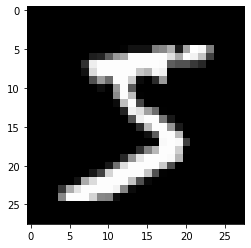

In [3]:
im, label = mnist_train[0]
plt.imshow(im, cmap='gray')
print(im, label)

### Convert to Tensor and A Custom torchvision.transformation for Binarization

In [4]:
class MyBinarization:
    """ convert a gray scale tensor [0, 1] to binary tensor of {0., 1.}"""
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def __call__(self, im):
        bright = im > self.threshold
        im[bright] = 1.
        im[~bright] = 0.
        return im

data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: (im>0.5).float()), # another way to do binarizaiton
                                     #MyBinarization() ,
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1)) # 
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

(torch.Size([784]), torch.float32, 5, array([0., 1.], dtype=float32), int, 784)

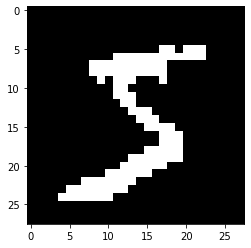

In [5]:
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
im.shape, im.dtype, label, np.unique(im), type(label), 28*28

## Bernoulli Naive Bayes
- https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch04_The_Preliminaries_A_Crashcourse/Naive_Bayes_Classification.ipynb

In [6]:
xcount = torch.ones((im.reshape(-1).shape[0],10)).float()
ycount = torch.ones((10))

for im, label in mnist_train:
    xcount[:,label] += im.reshape(-1)
    ycount[label] += 1
#

In [7]:
py = ycount / ycount.sum()
px = xcount / ycount.unsqueeze(0) # each row is divided by ycount

- For example, px[300,:] shows the Bernoulli probability at the location 300 for the class labels.
- px[300,**k**] is the probability of being a bright pixel at the location 300 provided the class is **k**

In [8]:
px[300,:]

tensor([0.6437, 0.0114, 0.3167, 0.1797, 0.3377, 0.1046, 0.0781, 0.4349, 0.4508,
        0.3057])

Class Conditional Probabilities: 


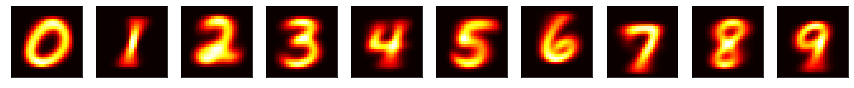

Class Prior Probabilities:
  tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [9]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional Probabilities: ')
for i in range(10):
    axes[i].imshow(px[:,i].reshape(28,28).numpy(), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()
print('Class Prior Probabilities:\n ', py)

* Notice that the images are well aligned within classes.

In [10]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

## PyTorch Neural Network

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.utils
import torch.nn as nn
import torch.optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
print (device)

cuda:0


## Data Preparation

In [12]:
data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1))
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

batch_size=4
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

torch.Size([784]) 5


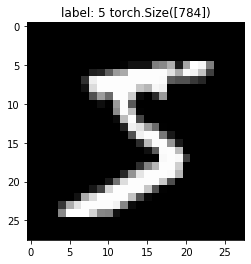

In [13]:
# Explore
im, label = mnist_train[0]

print(im.shape, label)
plt.imshow(im.reshape(28,28), cmap='gray')
plt.title(f'label: {label} {im.shape}');

torch.Size([4, 784])


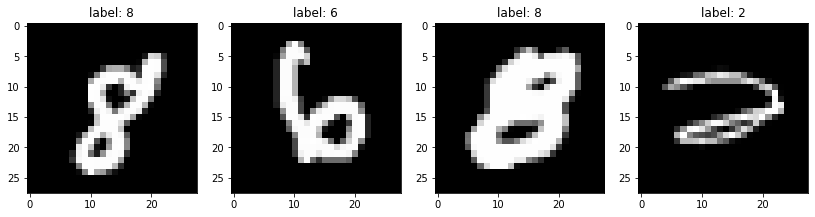

In [14]:
for batch_im, batch_label in data_loader_train:
    print(batch_im.shape)
    fig, axes = plt.subplots(1,batch_im.shape[0], figsize=(14,8))
    for i in range(batch_im.shape[0]):
        axes[i].imshow(batch_im[i].reshape(28,28), cmap='gray')
        axes[i].set_title(f'label: {batch_label[i]}')
    break

### Network Design

In [15]:
# Two hidden layer network

def myNetwork(in_features, n_targget):
    net = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=in_features//2),
        nn.Tanh(),
        nn.Linear(in_features=in_features//2, out_features=n_target),
        nn.LogSoftmax(dim=1)
        )
    return net
#

### Revise the action of `LogSoftMax()`

In [16]:
logsoftmax = nn.LogSoftmax(dim=1)
score_batch = torch.randn((4,10))
lsm = logsoftmax(score_batch) # log softmax along the dimension
print('Score Batch:\n', score_batch)
print('LogSoftMax:\n', lsm)
print('SoftMax:\n', torch.exp(lsm))
print('argmax(dim=1):\n', torch.argmax(lsm, dim=1))

Score Batch:
 tensor([[ 1.4865, -0.8443,  1.0740,  2.2261,  0.3534,  0.4047, -0.6629,  0.3191,
         -1.6380, -1.9132],
        [-0.2117,  0.9990,  1.9550,  1.1219,  1.8430,  0.0456, -0.2165, -0.3245,
          1.2224,  0.6789],
        [ 0.2304,  0.7242,  0.8036,  2.7772,  1.4557,  0.4169, -0.4762, -1.7281,
         -0.2936, -0.7935],
        [-0.3255,  0.1682,  1.3110,  1.5601, -0.6137, -0.7255,  0.4266, -0.2680,
          0.8182,  1.6000]])
LogSoftMax:
 tensor([[-1.6135, -3.9443, -2.0260, -0.8739, -2.7466, -2.6953, -3.7629, -2.7809,
         -4.7380, -5.0132],
        [-3.5409, -2.3303, -1.3742, -2.2073, -1.4862, -3.2836, -3.5457, -3.6537,
         -2.1068, -2.6503],
        [-3.1516, -2.6579, -2.5784, -0.6049, -1.9263, -2.9651, -3.8582, -5.1102,
         -3.6756, -4.1755],
        [-3.3660, -2.8724, -1.7295, -1.4805, -3.6542, -3.7660, -2.6139, -3.3085,
         -2.2223, -1.4405]])
SoftMax:
 tensor([[0.1992, 0.0194, 0.1319, 0.4173, 0.0641, 0.0675, 0.0232, 0.0620, 0.0088,
        

### Sanity Check with Dataset

In [17]:
in_features = 28*28
n_target = 10

model = myNetwork(in_features, n_target).to(device)
model, next(model.parameters()).is_cuda

(Sequential(
   (0): Linear(in_features=784, out_features=392, bias=True)
   (1): Tanh()
   (2): Linear(in_features=392, out_features=10, bias=True)
   (3): LogSoftmax()
 ), True)

In [18]:
# net working test
with torch.no_grad():
    for i in range(4):
        print(i, '------------------------------------')
        im_tensor, label = mnist_train[i]
        print(im_tensor.unsqueeze(0).shape)
        yp = model(im_tensor.unsqueeze(0).to(device)) # [Batch, data_features]
        pred = torch.argmax(yp, dim=1)
        print('log_P(y|x): ', yp)
        print('P(y|x): ', torch.exp(yp))
        print('argmax: ', pred.item())

0 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.1607, -2.4620, -2.3481, -2.1537, -2.2696, -2.3734, -2.2390, -2.4558,
         -2.3511, -2.2659]], device='cuda:0')
P(y|x):  tensor([[0.1152, 0.0853, 0.0956, 0.1161, 0.1034, 0.0932, 0.1066, 0.0858, 0.0953,
         0.1037]], device='cuda:0')
argmax:  3
1 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.3511, -2.4000, -2.4630, -2.2233, -2.1381, -2.3522, -2.2687, -2.3671,
         -2.1816, -2.3281]], device='cuda:0')
P(y|x):  tensor([[0.0953, 0.0907, 0.0852, 0.1083, 0.1179, 0.0952, 0.1034, 0.0938, 0.1129,
         0.0975]], device='cuda:0')
argmax:  4
2 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.1895, -2.2471, -2.4030, -2.3178, -2.3991, -2.3270, -2.1608, -2.3057,
         -2.3838, -2.3241]], device='cuda:0')
P(y|x):  tensor([[0.1120, 0.1057, 0.0904, 0.0985, 0.0908, 0.0976, 0.1152, 0.0997, 0.0922,
         0.0979]], device='cuda:0')


### Sanity Check with data_loader

In [19]:
with torch.no_grad():
    for im_batch, label_batch in data_loader_train:
        im_batch, label_batch = im_batch.to(device), label_batch.to(device)
        print(im_batch.shape, im_batch.dtype, label_batch.shape)
        yp = model(im_batch) # [Batch, data_features]
        pred = torch.argmax(yp, dim=1)
        print('log_P(y|x):\n', yp)
        print ('P(y|x): ', torch.exp(yp))
        print('argmax: ', pred)
        break

torch.Size([4, 784]) torch.float32 torch.Size([4])
log_P(y|x):
 tensor([[-2.3010, -2.4406, -2.3718, -2.1752, -2.2817, -2.4357, -2.2181, -2.3288,
         -2.2529, -2.2551],
        [-2.3043, -2.4708, -2.4631, -2.2629, -2.3402, -2.3079, -2.1760, -2.3640,
         -2.1613, -2.2261],
        [-2.3386, -2.4696, -2.5903, -2.1484, -2.2018, -2.3084, -2.2091, -2.3793,
         -2.2386, -2.2236],
        [-2.2179, -2.3657, -2.4479, -2.2596, -2.2880, -2.4000, -2.2968, -2.2839,
         -2.2714, -2.2201]], device='cuda:0')
P(y|x):  tensor([[0.1002, 0.0871, 0.0933, 0.1136, 0.1021, 0.0875, 0.1088, 0.0974, 0.1051,
         0.1049],
        [0.0998, 0.0845, 0.0852, 0.1040, 0.0963, 0.0995, 0.1135, 0.0940, 0.1152,
         0.1079],
        [0.0965, 0.0846, 0.0750, 0.1167, 0.1106, 0.0994, 0.1098, 0.0926, 0.1066,
         0.1082],
        [0.1088, 0.0939, 0.0865, 0.1044, 0.1015, 0.0907, 0.1006, 0.1019, 0.1032,
         0.1086]], device='cuda:0')
argmax:  tensor([3, 8, 3, 0], device='cuda:0')


### Training Loop

In [20]:
def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
  
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
        
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        model.train()
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()

            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        #
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
            
        # record for history return
        hist['tloss'].append(tr_loss)
        hist['vloss'].append(val_loss) 
        hist['tacc'].append(tr_acc)
        hist['vacc'].append(val_acc)
        
    print ('finished training_loop().')
    return hist

In [21]:
batch_size=128
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### optimizer & loss_function

In [22]:
model = myNetwork(in_features, n_target).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss().to(device)

In [23]:
history = training_loop(n_epochs=10,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test
                        )

Epoch 1, tloss 1.42 t_acc: 0.73  vloss 0.83  v_acc: 0.84
Epoch 2, tloss 0.67 t_acc: 0.85  vloss 0.54  v_acc: 0.87
Epoch 3, tloss 0.51 t_acc: 0.87  vloss 0.44  v_acc: 0.89
Epoch 4, tloss 0.44 t_acc: 0.88  vloss 0.40  v_acc: 0.90
Epoch 5, tloss 0.40 t_acc: 0.89  vloss 0.37  v_acc: 0.90
Epoch 10, tloss 0.33 t_acc: 0.91  vloss 0.31  v_acc: 0.91
finished training_loop().


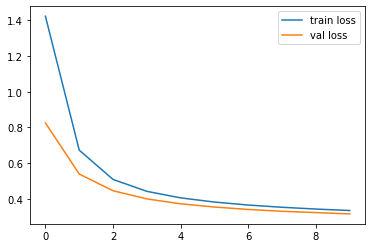

In [24]:
plt.plot(history['tloss'], label='train loss')
plt.plot(history['vloss'], label='val loss')
plt.legend();

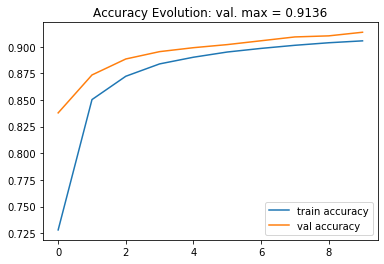

In [25]:
vmax = max(history['vacc'])
plt.title(f'Accuracy Evolution: val. max = {vmax}')
plt.plot(history['tacc'], label='train accuracy')
plt.plot(history['vacc'], label='val accuracy')
plt.legend();

### Do some more training

In [26]:
history = training_loop(n_epochs=50,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history)

Epoch 1, tloss 0.33 t_acc: 0.91  vloss 0.31  v_acc: 0.91
Epoch 2, tloss 0.32 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 3, tloss 0.32 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 4, tloss 0.31 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 5, tloss 0.31 t_acc: 0.91  vloss 0.29  v_acc: 0.92
Epoch 50, tloss 0.20 t_acc: 0.94  vloss 0.20  v_acc: 0.94
finished training_loop().


In [27]:
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    axes[1].set_title('Acc: vmax = '+str(max(history['vacc'])))
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()

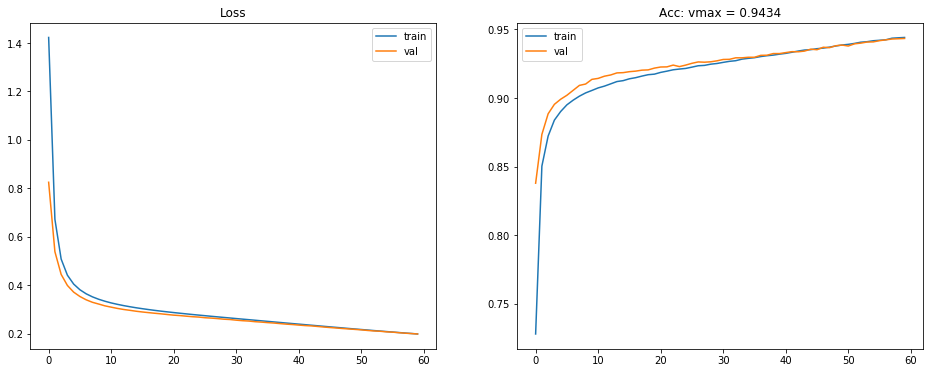

In [28]:
plot_history(history)

Epoch 1, tloss 0.20 t_acc: 0.94  vloss 0.20  v_acc: 0.95
Epoch 2, tloss 0.20 t_acc: 0.95  vloss 0.20  v_acc: 0.94
Epoch 3, tloss 0.19 t_acc: 0.95  vloss 0.19  v_acc: 0.94
Epoch 4, tloss 0.19 t_acc: 0.95  vloss 0.19  v_acc: 0.95
Epoch 5, tloss 0.19 t_acc: 0.95  vloss 0.19  v_acc: 0.95
Epoch 250, tloss 0.05 t_acc: 0.99  vloss 0.08  v_acc: 0.98
finished training_loop().


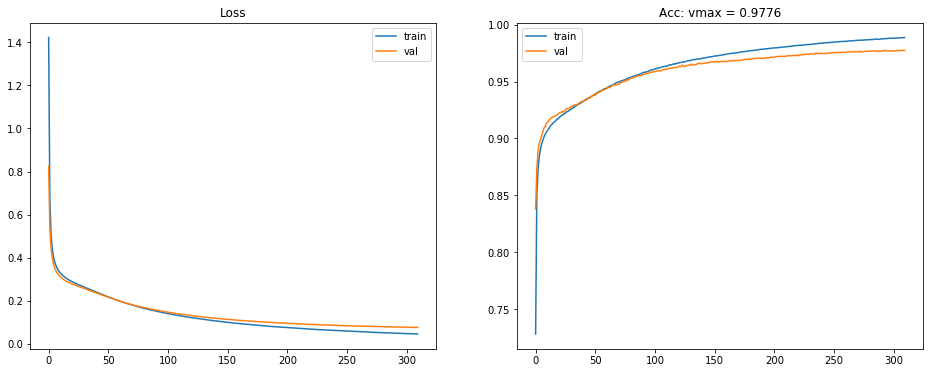

In [29]:
history = training_loop(n_epochs=250,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history)
plot_history(history)

### Practicums
- Modify batch_size to examine the behavior of the training loop.
- Try other values of learning_rate
- Try Adam
    - what is Adam by the way?